To start with you need to configure your Red Pitaya like so, we are going to repeat the same tests we did with the scope but now with a little bit of python code. 
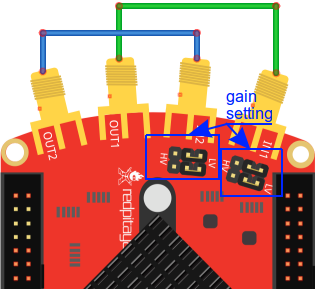

First We will load the redpitaya. We will load an overlay. An Overlay is a fancy word for FPGA firmware. What this is actully doing is loading precompiled code onto your FPGA. The code in this case runs a simple oscilliscope and generator. It looks exactly like the tool that you used in the past. 

In [1]:
from redpitaya.overlay.mercury import mercury as overlay
fpga = overlay()

Requested overlay is already loaded.


The first thing to do with the Red Pitaya is to blink some LEDs. The Overlay points to memory addresses that will turn on and off the LEDs on the board. Effectively all you need to do is set a certain address to be zero or 1 to turn on or off the LED.

In [2]:
import time
LEDs = fpga.led
led3 = LEDs(3,0)            # First arg is which LED you're selecting, the second arg is the initial state of the LED, 
                            # either ON (1) or OFF (0)
for _ in range(1):         # Blink the LED 10 times
    led3.write(1)           # turn ON
    time.sleep(1)           # wait one second
    led3.write(0)           # turn off
    time.sleep(1)           # wait one second

Now that we have this. The first and simplest thing that we can do is to generate a signal from the redpitaya. To generate from the red pitaya. All we need to do is load the gen function. There are two output channels (0,1). So lets just load the output of one of them.

In [3]:
gen0 = fpga.gen(0)#note this could be 1
print(gen0)

Now we can just set the waveform to something that we want. 

In [4]:
gen0.amplitude = 1.0
gen0.offset    = 0.0
gen0.waveform  = gen0.sin()

[ 0.          0.0003835   0.00076699 ..., -0.00115049 -0.00076699
 -0.0003835 ]


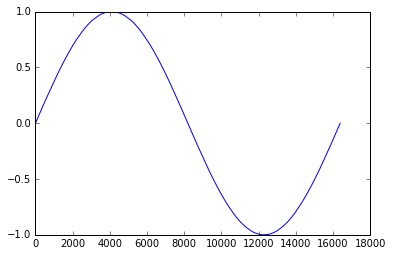

In [5]:
#Lets take a look at what we did
import matplotlib.pyplot as plt
print(gen0.sin())
plt.plot(gen0.waveform)
plt.show()

So what we have done is filled a fine array with 16384 (2^14) points with a finely grained sin funciton. This array is then used to construct a harmonic pulse. This array is then read sequentially point by point and used to output the pulse into the output. Namely, we first read gen0.waveform[0], then we read gen0.waveform[1] and so on and so forth. However in order to do that we need to make sure we register the Red pitaya to repeat this and we need to pick a frequency for this. 

In [14]:
gen0.mode = 'PERIODIC'
gen0.frequency = 100000 #100 kHz

Now we can tell the red pitaya to star sending out the signals. Lock and load.

In [18]:
gen0.reset()
gen0.start()
gen0.enable = True
gen0.trigger()

Now what we want to do is read the input of the scope. To do that we need to make an instance of the inputs from the FPGA. Like the generator instance we can also configure this with trigger and whatever else we want

In [8]:
osc0 = fpga.osc(0, 1.0)#note the 1.0 is for the voltage range either 1.0 or 20.0 volts
print(osc0)

This again an instance that points to memory addresses. One is a buffer that is continuously being filled with the new inputs from the FPGA every time there is a trigger. The other pointers point to configurations of the of the trigger to readout the scope. Lets readout a random set of data without a trigger. 

In [19]:
#Reset the readin and start it up
size = osc0.buffer_size
buff = osc0.data(size)
print(buff)

[-0.15381329 -0.15356913 -0.15369122 ...,  0.60744041  0.60805076
  0.60634172]


And lets plot it as well. 

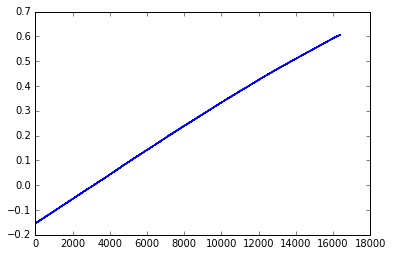

In [20]:
plt.plot(buff)
plt.show()

Now lets setup a real trigger for how to read this guy out. Here is the code for the readout (for reference) https://github.com/RedPitaya/jupyter/blob/ec3ebaa41000006b0b18e963661858bbf4989903/redpitaya/drv/osc.py#L14. You can go lower in the directories to see the other details. For example te trigger info is here: 
https://github.com/RedPitaya/jupyter/blob/ec3ebaa41000006b0b18e963661858bbf4989903/redpitaya/drv/osc_trg.py. In light of not confusing you ,I will list the options you actually should care about below. What we will do is set a trigger to be positive with a threshold of 0.05 volts and we will put ample space around the pulse

In [26]:
#we will save 1/4 of the buffer before the pulse and 3/4 of the buffer after
osc0.trigger_pre  = size//4*1 # Note that // means divide and floor(round down) output 
osc0.trigger_post = size//4*3
#osc0.sync_src = fpga.sync_src["osc0"] #Points to a software trigger (ie from the generator)
osc0.trig_src = fpga.trig_src["osc0"]  #Points the trigger to go from the same channel
osc0.level = 0.05   # This is the trigger threshold in Volts
osc0.edge  = 'pos'  # options : 'pos' or 'neg' (slope to trigger on)

#Advanced Options would be fun to include the filter
#https://github.com/RedPitaya/jupyter/blob/ec3ebaa41000006b0b18e963661858bbf4989903/redpitaya/drv/osc_fil.py


Now lets turn on the trigger and see what we have gotten.

triggered


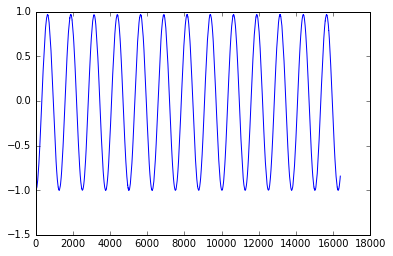

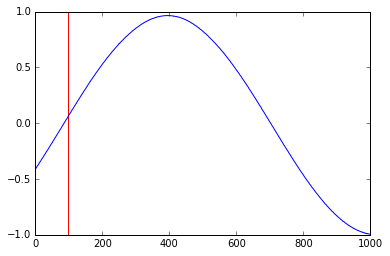

In [27]:
osc0.reset()
osc0.start()
while (osc0.status_run()): pass
print('triggered')
buff = osc0.data(size)
plt.plot(buff)
plt.show()
#Now lets zoom in around the triggered pulse
plt.axvline(size//4-4000,c='r') #This is the trigger line
plt.plot(buff[4000:5000])
plt.show()

triggered


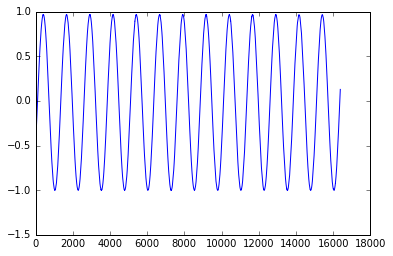

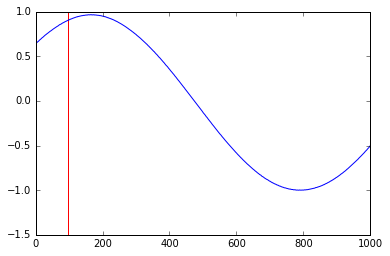

In [24]:
#Now lets change the trigger threshold
osc0.level = 0.9
osc0.reset()
osc0.start()
while (osc0.status_run()): pass
print('triggered')
buff = osc0.data(size)
plt.plot(buff)
plt.show()
#Now lets zoom in around the triggered pulse
plt.axvline(size//4-4000,c='r') #This is the trigger line
plt.plot(buff[4000:5000])
plt.show()

Now lets play around with the trigger a little bit by changing to a software trigger

triggered


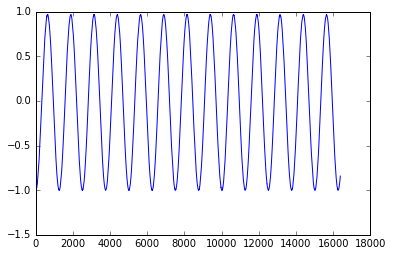

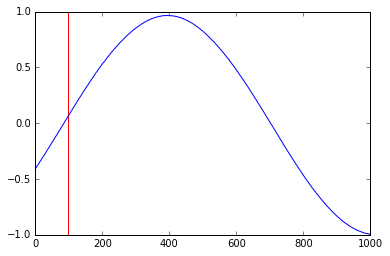

In [29]:
osc0.sync_src = fpga.sync_src["osc0"]
osc0.reset()
osc0.start()
while (osc0.status_run()): pass
print('triggered')
buff = osc0.data(size)
plt.plot(buff)
plt.show()
#Now lets zoom in around the triggered pulse
plt.axvline(size//4-4000,c='r') #This is the trigger line
plt.plot(buff[4000:5000])
plt.show()

So now lets show all of the possible things we can set for the generator.

In [31]:
#Now for completeness lets print out all addresses of the oscillator
print("Oscillator:")
osc0.show_regset()
#And Lets list the generator pointers
print("Generator:")
gen0.show_regset()

Oscillator:
ctl_sts = 0x0000000c =         12  # control/status        
cfg_evn = 0x00000002 =          2  # SW event source select
cfg_trg = 0x00000004 =          4  # HW trigger mask       

cfg_pre = 0x00001000 =       4096  # delay pre  trigger        
cfg_pst = 0x00003000 =      12288  # delay post trigger        
sts_pre = 0x000012a2 =       4770  # status pre  trigger       
sts_pst = 0x00003000 =      12288  # status post trigger       

cfg_neg = 0x00000666 =       1638  # negative level     
cfg_pos = 0x00000666 =       1638  # positive level     
cfg_edg = 0x00000000 =          0  # edge (0-pos, 1-neg)

cfg_dec = 0x00000000 =          0  # decimation factor
cfg_shr = 0x00000000 =          0  # shift right      
cfg_avg = 0x00000000 =          0  # average enable   
cfg_byp = 0x00000000 =          0  # bypass           
cfg_faa = 0x00007d93 =      32147  # AA coeficient    
cfg_fbb = 0x000437c7 =     276423  # BB coeficient    
cfg_fkk = 0x00d9999a =   14260634  # KK coeficie

Finally run this a real-time monitoring system of this using some tools on the Red Pitaya. This makes life a lot easier for debugging. Below is maybe the most complex code in the whole thing, so we can walk through it. 

In [ ]:
#Setup realtime monitoring system
from bokeh.io import push_notebook, show, output_notebook    #Commands for updating plots
from bokeh.models import HoverTool, Range1d                  #Commands for hoeveing over the plot
from bokeh.plotting import figure                            #Plotting tool
from bokeh.resources import INLINE                           #Other resources
output_notebook(resources=INLINE)                            #Start the image

x = np.arange(size)                                          #Make an array the size of the trigger output
colors = ('red', 'blue')                                     #Pick two colors
hover = HoverTool(mode = 'vline', tooltips=[("T", "@x"), ("V", "@y")]) #Nice hover tool
tools = "pan,wheel_zoom,box_zoom,reset,crosshair"                      #fun viwer tools
p = figure(plot_height=500, plot_width=900, title="oscilloscope", toolbar_location="above", tools=(tools, hover))#figure
p.xaxis.axis_label='time [s]'                                # Put label on x-axis
p.yaxis.axis_label='voltage [V]'                             # Put label on y-axis
p.y_range=Range1d(-1.2, 1.2)                                 # Put a range on the y-axis
r = p.line(x, buff, line_width=1, line_alpha=0.7, color=colors[0])  # Plot the initial setup
target = show(p, notebook_handle=True)                       # Plot this guy

Now we are going to continuously run this with a continuous while loop. 

In [ ]:
#Continuously run reading the trigger and writing to text events that pass the trigger
while True:
    osc0.reset()                            #reset
    osc0.start()                            #Start it up
    while osc0.status_run(): pass           #Keep running until the trigger passes
    buff = osc0.data(size)                  #Get the data and plot it
    r.data_source.data['y'] = buff          #Plot the pulse
    push_notebook(handle=target)            #Push this guy

Now prove that the above is continuous by unplugging the cable. Convince your self that you are reading in real time. If you want to stop the above you can always just click stop in the jupyter notebook. Now to get you thinking, lets plot something different the pulse, lets plot a histogram of the max pulse after each trigger. This is sometimes referred to as the output of a multichannel analyzer

In [ ]:
#Lets use this real-time plotting setup
nbins=100
x = np.arange(nbins)/100.                                          #X-axis
y = np.zeros(nbins)                                           #Y-axis
p = figure(plot_height=500, plot_width=900, title="Realtime Histo", toolbar_location="above", tools=(tools, hover))#figure
p.yaxis.axis_label='N'                                # Put label on x-axis
p.xaxis.axis_label='voltage [V]'                      # Put label on y-axis
p.y_range=Range1d(0,1000)                          # Put a range on the y-axis
r2 = p.line(x, buff, line_width=1, line_alpha=0.7, color=colors[0])  # Plot the initial setup
target2 = show(p, notebook_handle=True)                       # Plot this guy


In [ ]:
#Lets make a function that fills our array
def fillBins(iData,iY):
    maxval=np.max(iData)*100
    if maxval < 0:
        maxval=0
    if maxval > 100:
        maxval=100
    iY[int(maxval)] = iY[int(maxval)] +1
    
y = np.zeros(nbins)                                           #Y-axis
while True:
    osc0.reset()                            #reset
    osc0.start()                            #Start it up
    while osc0.status_run(): pass           #Keep running until the trigger passes
    buff = osc0.data(size)                  #Get the data and plot it
    fillBins(buff,y)
    #r.data_source.data['y'] = buff          #Plot the pulse
    #push_notebook(handle=target)            #Push this guy
    r2.data_source.data['y'] = y            #Plot the pulse
    push_notebook(handle=target2)           #Push this guy
    

Now that you have walked through how to do this. There are a few steps that you can do to play with this. Here is what you should do: 

1. The first thing is to get this setup to work on the Cosmic Watch
2. Once you have it working plot the energy distribution of cosmic muons going through the sample. What is the distribution? What does it look like? 
3. Think about other things you might be able to read with this setup? Nuclear radiation? 
4. Now, lets make a muon telescope. Hook up two cosmic watches together and setup a synchronized trigger by requiring two pulses to appear nearby? What sort of conditions are needed to tie them together? 
5. Now we are ready to do a lot of things, perhaps the muonlifetime? 